# Parallelization of Simulation and Optimization

For the sake of simplicity, we import classes from the standard use case of rabi
driving in the rotating frame with xy control, as this section focuses solely on
the parallelization. (It is the same Example as in the last sections.)

## Parallel evaluation of Monte Carlo simulations

Monte Carlo simulations can become very costly, if many noise traces are
required to suppress statistical uncertainties, and the pulse needs to be
sampled at very small time steps $\delta t$ to increase the maximal noise
frequency which can be resolved $f_{max} = 1/ \delta t$.

The computational time can be reduced by performing the simulation for multiple
noise samples in parallel.

In [1]:
import matplotlib.pyplot as plt
from qopt.examples.rabi_driving.rabi_xy_setup import *
import time

n_pulses = 10
random_pulses = np.random.rand(n_pulses, n_time_samples, len(qs_solver.h_ctrl))

monte_carlo_solver = solver_colored_noise_xy
monte_carlo_solver.set_optimization_parameters(random_pulses[0])

We start by calculating the propagators without parallelization and take the
time.

In [2]:
monte_carlo_solver.processes = 1
start = time.time()
_ = monte_carlo_solver.propagators
end = time.time()
print('sequentiel execution')
print(end - start)

sequentiel execution
52.936718225479126


Then we continue do the same using the parallel evaluation.
(We need to reset the optimization parameters, as otherwise the solver will
return the
stored propagators from the previous call.

In [3]:
monte_carlo_solver.set_optimization_parameters(0 * random_pulses[0])
monte_carlo_solver.set_optimization_parameters(random_pulses[0])

# By setting the number of processes to None, the program uses the number of
# kernels in your CPU.
monte_carlo_solver.processes = None
start = time.time()
_ = monte_carlo_solver.propagators
end = time.time()
print('parallel execution')
print(end - start)

parallel execution
18.36955976486206


## Parallel Optimization

Gradient based optimization algorithms often require many initial
values because they tend to get stuck in local minima. Fortunately this task
has a trivial parallelization. We simply conduct the same optimization with
different initial conditions on multiple cores.

parallel execution
100.77676844596863


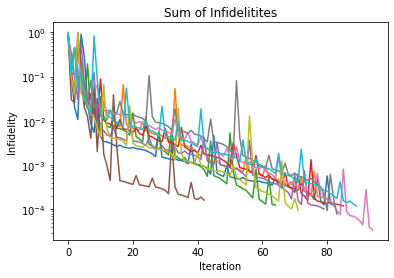

Total execution time:
818.7418937683105


In [4]:
from qopt import *

n_optimizations = 10
random_pulses = np.random.rand(
    n_optimizations, n_time_samples, len(qs_solver.h_ctrl))

start = time.time()
data = run_optimization_parallel(optimizer, initial_pulses=random_pulses,
                                 processes=None)
end = time.time()
print('parallel execution')
print(end - start)

analyser = Analyser(data)
analyser.plot_absolute_costs()
plt.show()

print('Total execution time:')
print(analyser.total_cost_fkt_time() + analyser.total_grad_fkt_time())

When performed on a 6 core CPU the parallel calculation showed a decent
speedup of about a factor of 4.5.

## Parallel Simulation

If you want to use just the Simulation tools then here you can find an example of
easy parallelization using the native multiprocessing package:

In [5]:
from qopt.examples.rabi_driving.rabi_xy_setup import *
from multiprocessing import Pool


n_pulses = 10
random_pulses = np.random.rand(n_pulses, n_time_samples, len(qs_solver.h_ctrl))

start_parallel = time.time()
with Pool(processes=None) as pool:
    infids = pool.map(simulate_propagation, random_pulses)
end_parallel = time.time()
parallel_time = end_parallel - start_parallel

start_sequential = time.time()
infids_sequential = list(map(simulate_propagation, random_pulses))
end_sequential = time.time()
sequential_time = end_sequential - start_sequential

In [6]:
print('parallel execution')
print(parallel_time)
print('sequential execution')
print(sequential_time)

parallel execution
80.65793561935425
sequential execution
180.2660403251648
